In [6]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

import json

from sklearn.metrics import classification_report, roc_curve, auc

import seaborn as sns

#===========================

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from noise_scheduler import PinkNoiseScheduler

# Results 

## WSD107

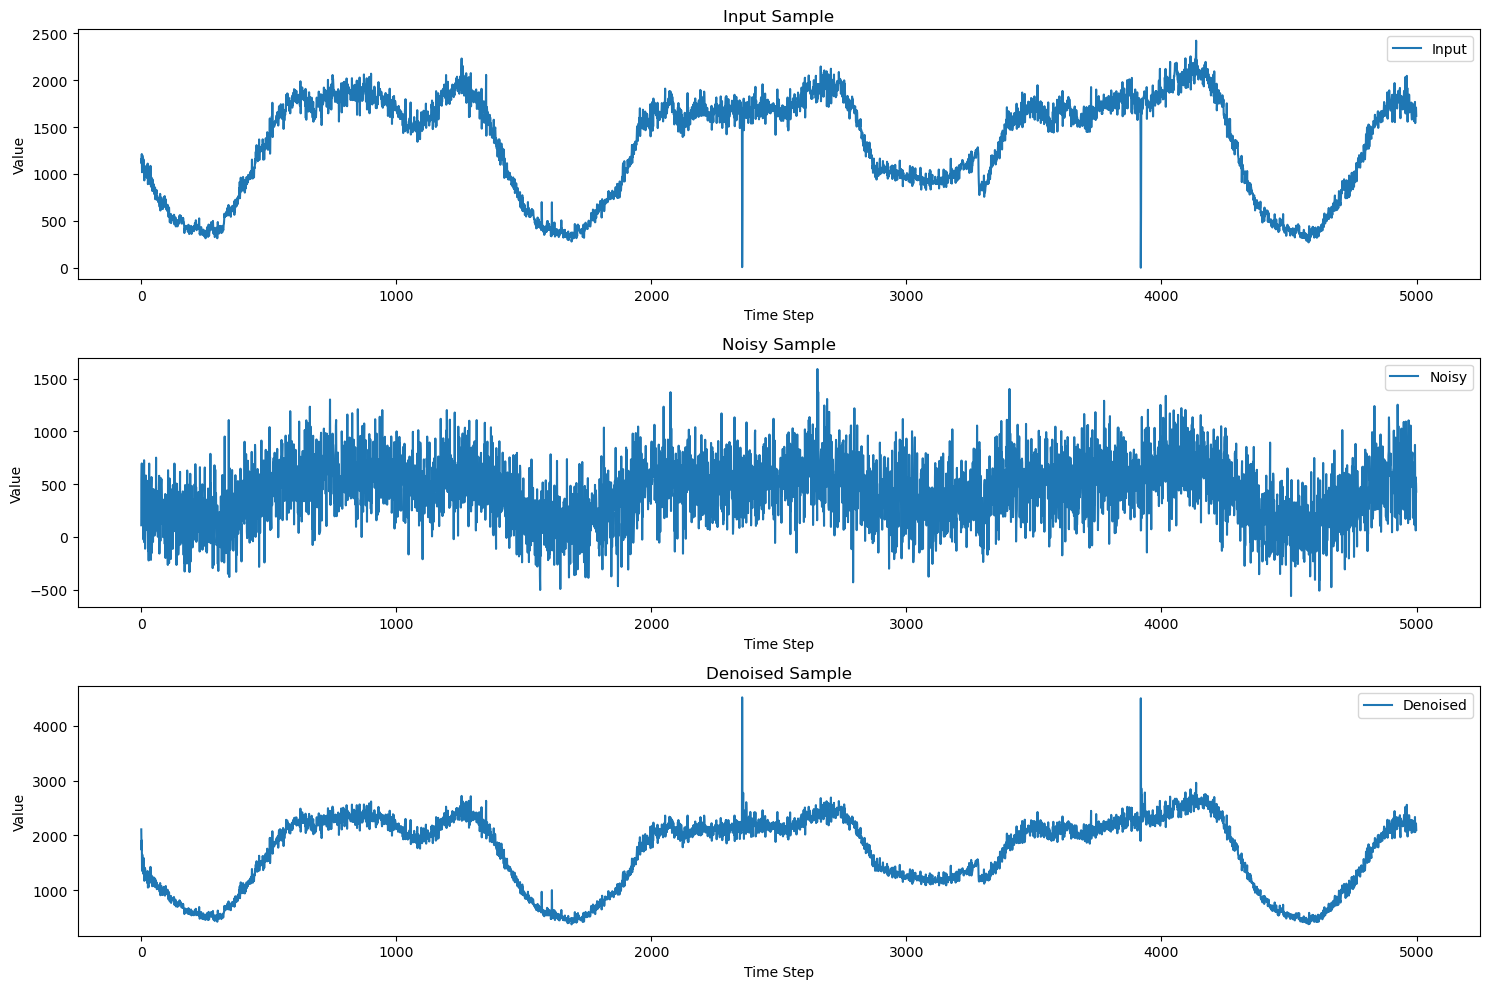
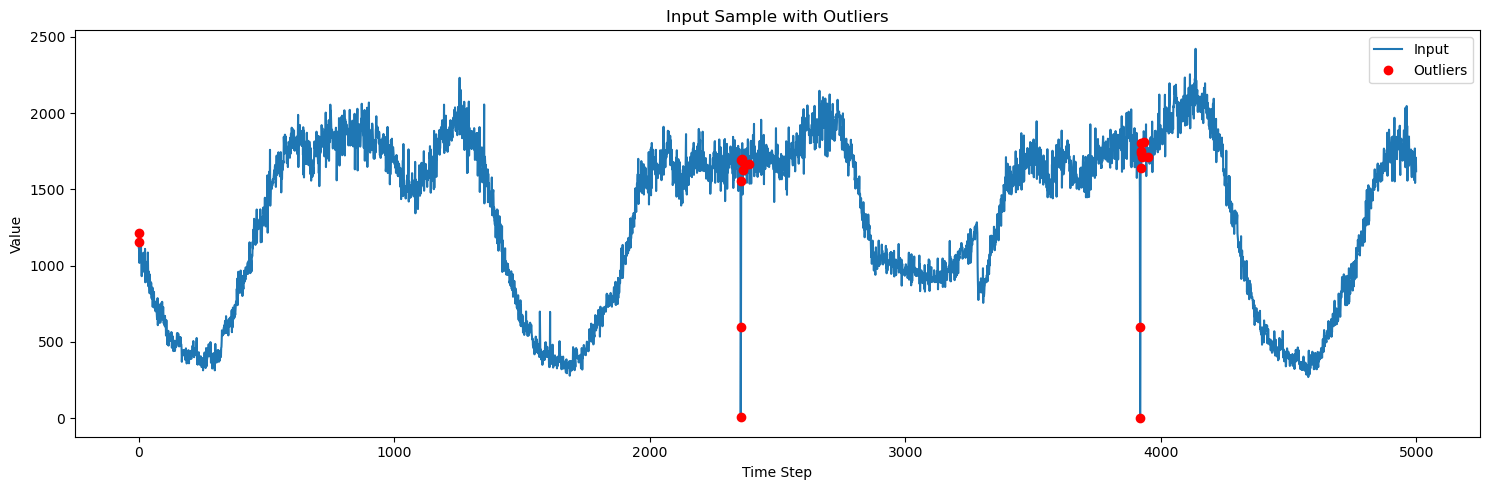

eval timesteps tensor([467, 800, 175,  81, 682, 991, 817, 240, 638, 970, 610, 752, 219, 332,
        400,  91])
Best threshold: tensor(686.2314)
Best F1 score: 0.48148148148148145
Best AUPRC score: 0.25272941176470587
Best Precision score: 0.65
Best Recall score: 0.38235294117647056
Best threshold: tensor(686.2314)
Best F1 score: 0.43478260869565216
Best AUPRC score: 0.2188654064272212
Best Precision score: 0.6521739130434783
Best Recall score: 0.32608695652173914
Best threshold: tensor(686.2314)
Best F1 score: 0.379746835443038
Best AUPRC score: 0.18288944099378884
Best Precision score: 0.6521739130434783
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.39473684210526316
Best AUPRC score: 0.20909285714285716
Best Precision score: 0.75
Best Recall score: 0.26785714285714285
Best threshold: tensor(686.2314)
Best F1 score: 0.38571428571428573
Best AUPRC score: 0.18638522727272727
Best Precision score: 0.6136363636363636
Best Recall score: 0.28125
Best threshold: tensor(686.2314)
Best F1 score: 0.37142857142857144
Best AUPRC score: 0.17192865497076024
Best Precision score: 0.5777777777777777
Best Recall score: 0.2736842105263158
Best threshold: tensor(580.6574)
Best F1 score: 0.39
Best AUPRC score: 0.16368120300751882
Best Precision score: 0.37142857142857144
Best Recall score: 0.4105263157894737
Best threshold: tensor(686.2314)
Best F1 score: 0.3950617283950617
Best AUPRC score: 0.1907829903978052
Best Precision score: 0.5925925925925926
Best Recall score: 0.2962962962962963
Best threshold: tensor(791.8055)
Best F1 score: 0.3508771929824561
Best AUPRC score: 0.17153015873015873
Best Precision score: 0.6666666666666666
Best Recall score: 0.23809523809523808
Best threshold: tensor(580.6574)
Best F1 score: 0.4528301886792453
Best AUPRC score: 0.21531428571428568
Best Precision score: 0.48
Best Recall score: 0.42857142857142855
Best threshold: tensor(686.2314)
Best F1 score: 0.3875968992248062
Best AUPRC score: 0.17714391534391535
Best Precision score: 0.5555555555555556
Best Recall score: 0.2976190476190476
Best threshold: tensor(686.2314)
Best F1 score: 0.3902439024390244
Best AUPRC score: 0.1664627450980392
Best Precision score: 0.47058823529411764
Best Recall score: 0.3333333333333333
Best threshold: tensor(580.6574)
Best F1 score: 0.4626865671641791
Best AUPRC score: 0.2214777777777778
Best Precision score: 0.4305555555555556
Best Recall score: 0.5
Best threshold: tensor(791.8055)
Best F1 score: 0.4485981308411215
Best AUPRC score: 0.23817142857142856
Best Precision score: 0.6857142857142857
Best Recall score: 0.3333333333333333
Best threshold: tensor(791.8055)
Best F1 score: 0.49056603773584906
Best AUPRC score: 0.25528809523809526
Best Precision score: 0.6190476190476191
Best Recall score: 0.40625
Best threshold: tensor(791.8055)
Best F1 score: 0.5454545454545454
Best AUPRC score: 0.3549739130434783
Best Precision score: 0.9
Best Recall score: 0.391304347826087
F1 score: 0.4226128636115364
AUPRC score: 0.21104484446841024
Precision score: 0.6042444405847539
Recall score: 0.33965110842519053

## NAB "../datasets/UTS/NAB/Twitter_volume_CVS"

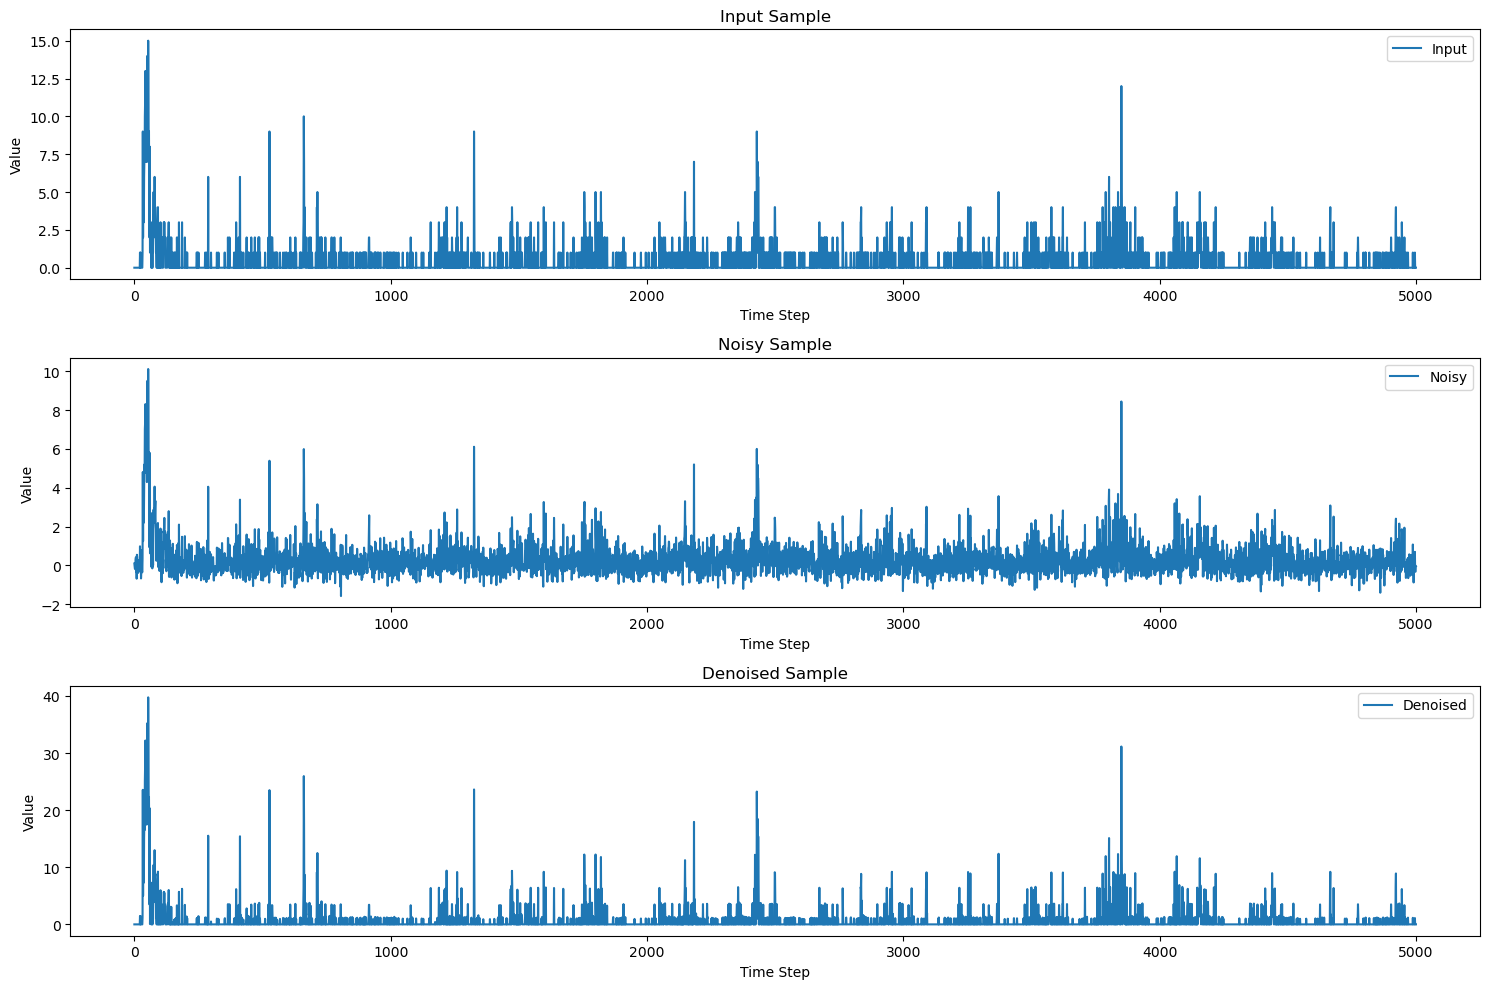
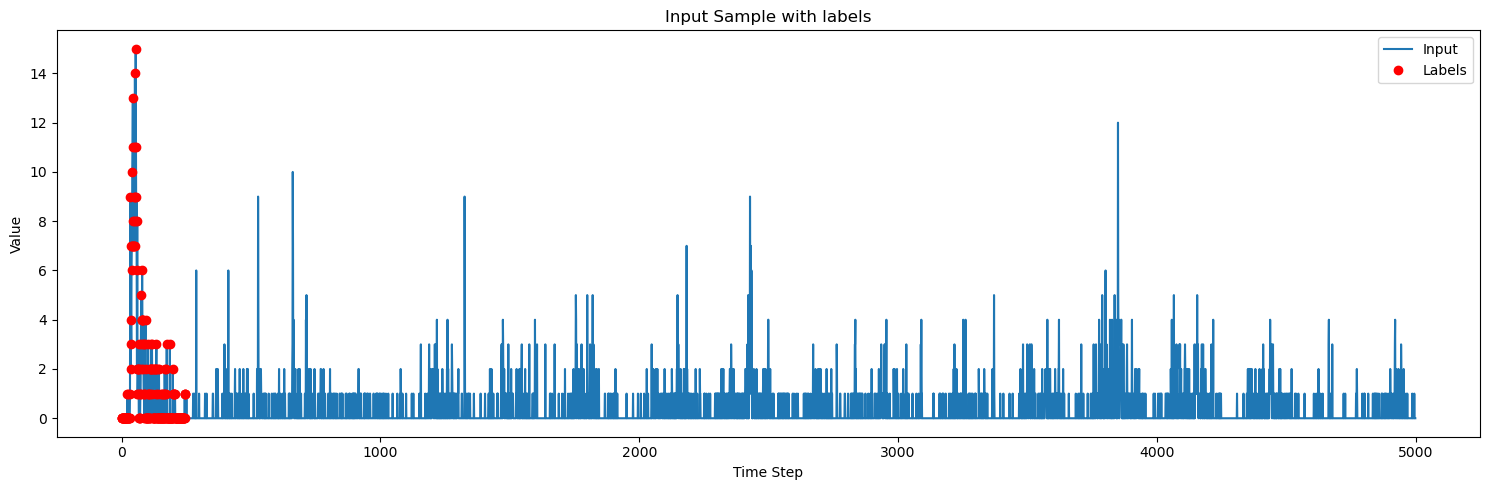
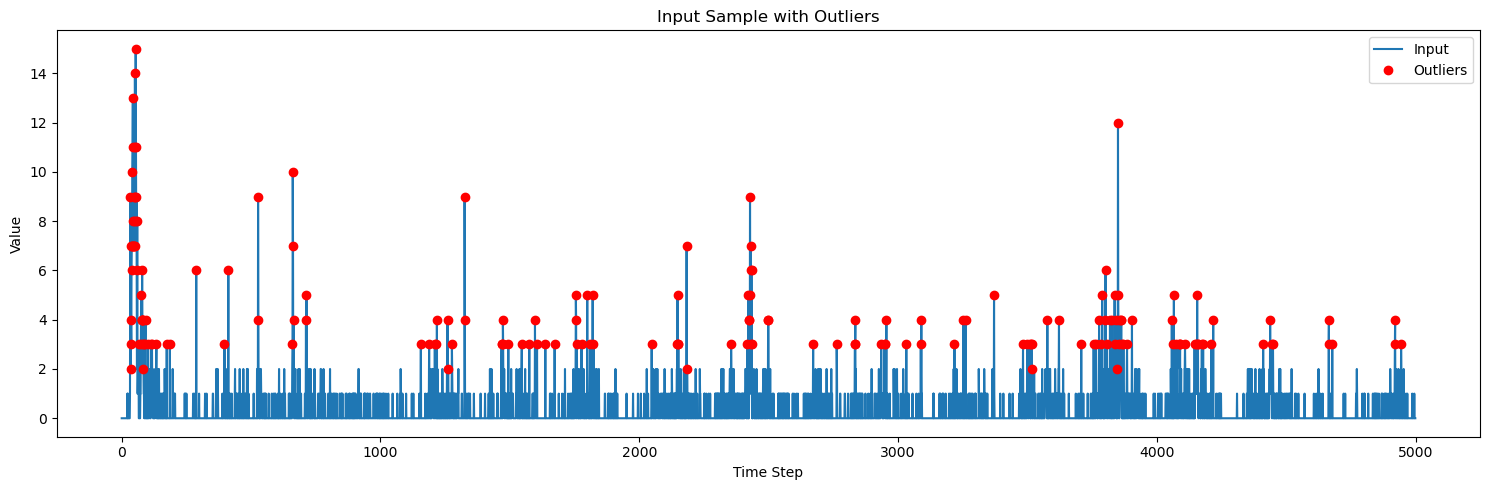

eval timesteps tensor([866, 361, 790, 296])
Best threshold: tensor(2.3182)
Best F1 score: 0.21809744779582366
Best AUPRC score: 0.08860499911987327
Best Precision score: 0.2554347826086957
Best Recall score: 0.1902834008097166
Best threshold: tensor(1.2143)
Best F1 score: 0.027649769585253458
Best AUPRC score: 0.015509614754992906
Best Precision score: 0.01680672268907563
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.7727)
Best F1 score: 0.12422360248447205
Best AUPRC score: 0.08503343251885967
Best Precision score: 0.12285012285012285
Best Recall score: 0.12562814070351758
Best threshold: tensor(0.7727)
Best F1 score: 0.12195121951219512
Best AUPRC score: 0.08448485079425565
Best Precision score: 0.11848341232227488
Best Recall score: 0.12562814070351758
F1 score: 0.12298050984443606
AUPRC score: 0.06840822429699538
Precision score: 0.12839376011754228
Recall score: 0.1298654400347074

# Complete Evaluation

In [3]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [4]:
# training testing imports 
import train_test_fonctions
from train_test_fonctions import calculate_f1_auprc_score, plot_samples, plot_predictions, trainer, tester, train_tracker, z_score_outliers, modified_z_score_outliers, iqr_outliers, iqr_collective_outliers
from train_test_fonctions import train_model, test_model, process_directory, trainer_all_in_one

## WSD dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [ ]:
import os

data_folder = "../datasets/UTS/WSD"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


# NAB dataset - all in one 

Change the output folder name ! 

In [5]:
# config for NAB dataset
base_config = {
  "data_path":  "../datasets/UTS/NAB",
  "output_dir": "output_NAB_pink3",
  "train_batch_size": 3,
  "eval_batch_size": 1,
  "num_epochs": 20,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.3,
  "save_model_epochs": 1
}

sequence_length = 2500
input_size = 1  # Assuming 1D time series data
stride = 100


In [6]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[64, 128,256,512,256,128,64,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"

#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(sequence_length, stride, base_config, config, model, noise_scheduler, data_folder)


Training model...


  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 3372.03173828125, 'epoch': 0}
{'loss': 2027.2730712890625, 'epoch': 0}
{'loss': 42.11581802368164, 'epoch': 0}
{'loss': 0.7029178142547607, 'epoch': 0}
{'loss': 420.5467224121094, 'epoch': 0}
{'loss': 324.9446105957031, 'epoch': 0}
{'loss': 13.431506156921387, 'epoch': 0}
{'loss': 392.9465637207031, 'epoch': 0}
{'loss': 2.6347484588623047, 'epoch': 0}


  7%|▋         | 1/15 [00:15<03:38, 15.62s/it]

{'loss': 188.2163543701172, 'epoch': 0}
{'loss': 8508.4482421875, 'epoch': 1}
{'loss': 2966.814697265625, 'epoch': 1}
{'loss': 37.830322265625, 'epoch': 1}
{'loss': 0.937402069568634, 'epoch': 1}
{'loss': 283.8028869628906, 'epoch': 1}
{'loss': 393.74212646484375, 'epoch': 1}
{'loss': 17.006166458129883, 'epoch': 1}
{'loss': 420.2495422363281, 'epoch': 1}
{'loss': 6.844614505767822, 'epoch': 1}


 13%|█▎        | 2/15 [00:31<03:25, 15.82s/it]

{'loss': 115.5011215209961, 'epoch': 1}
{'loss': 3354.797607421875, 'epoch': 2}
{'loss': 2592.88427734375, 'epoch': 2}
{'loss': 33.5020866394043, 'epoch': 2}
{'loss': 1.1461286544799805, 'epoch': 2}
{'loss': 227.2101287841797, 'epoch': 2}
{'loss': 373.93359375, 'epoch': 2}
{'loss': 16.279573440551758, 'epoch': 2}
{'loss': 806.4274291992188, 'epoch': 2}
{'loss': 10.030274391174316, 'epoch': 2}


 20%|██        | 3/15 [00:47<03:12, 16.06s/it]

{'loss': 130.6988525390625, 'epoch': 2}
{'loss': 2840.838134765625, 'epoch': 3}
{'loss': 2658.74072265625, 'epoch': 3}
{'loss': 23.591106414794922, 'epoch': 3}
{'loss': 1.2540628910064697, 'epoch': 3}
{'loss': 373.3954772949219, 'epoch': 3}
{'loss': 524.6246948242188, 'epoch': 3}
{'loss': 13.286242485046387, 'epoch': 3}
{'loss': 371.649658203125, 'epoch': 3}
{'loss': 6.420057773590088, 'epoch': 3}


 27%|██▋       | 4/15 [01:04<02:59, 16.30s/it]

{'loss': 102.27932739257812, 'epoch': 3}
{'loss': 4008.146728515625, 'epoch': 4}
{'loss': 2212.074462890625, 'epoch': 4}
{'loss': 45.61370849609375, 'epoch': 4}
{'loss': 0.9171305298805237, 'epoch': 4}
{'loss': 359.64263916015625, 'epoch': 4}
{'loss': 413.1521301269531, 'epoch': 4}
{'loss': 16.02508544921875, 'epoch': 4}
{'loss': 342.2632141113281, 'epoch': 4}
{'loss': 4.289752960205078, 'epoch': 4}


 33%|███▎      | 5/15 [01:20<02:43, 16.33s/it]

{'loss': 140.447265625, 'epoch': 4}
{'loss': 4195.43701171875, 'epoch': 5}
{'loss': 240.95907592773438, 'epoch': 5}
{'loss': 47.70114517211914, 'epoch': 5}
{'loss': 1.7553869485855103, 'epoch': 5}
{'loss': 315.3919982910156, 'epoch': 5}
{'loss': 289.0390319824219, 'epoch': 5}
{'loss': 19.561817169189453, 'epoch': 5}
{'loss': 550.7785034179688, 'epoch': 5}
{'loss': 4.111671447753906, 'epoch': 5}


 40%|████      | 6/15 [01:37<02:26, 16.32s/it]

{'loss': 155.4487762451172, 'epoch': 5}
{'loss': 3536.989013671875, 'epoch': 6}
{'loss': 2772.966552734375, 'epoch': 6}
{'loss': 48.365909576416016, 'epoch': 6}
{'loss': 1.3560115098953247, 'epoch': 6}
{'loss': 291.4298095703125, 'epoch': 6}
{'loss': 391.39404296875, 'epoch': 6}
{'loss': 23.770336151123047, 'epoch': 6}
{'loss': 671.6417846679688, 'epoch': 6}
{'loss': 4.931944847106934, 'epoch': 6}


 47%|████▋     | 7/15 [01:54<02:12, 16.58s/it]

{'loss': 145.2949676513672, 'epoch': 6}
{'loss': 3183.70068359375, 'epoch': 7}
{'loss': 3471.5205078125, 'epoch': 7}
{'loss': 41.01985168457031, 'epoch': 7}
{'loss': 2.5857810974121094, 'epoch': 7}
{'loss': 55.70632553100586, 'epoch': 7}
{'loss': 489.8092041015625, 'epoch': 7}
{'loss': 21.23158836364746, 'epoch': 7}
{'loss': 397.4879150390625, 'epoch': 7}
{'loss': 8.422138214111328, 'epoch': 7}


 53%|█████▎    | 8/15 [02:11<01:56, 16.66s/it]

{'loss': 98.08805847167969, 'epoch': 7}
{'loss': 1973.5084228515625, 'epoch': 8}
{'loss': 2803.185791015625, 'epoch': 8}
{'loss': 51.168113708496094, 'epoch': 8}
{'loss': 2.442964792251587, 'epoch': 8}
{'loss': 399.7061462402344, 'epoch': 8}
{'loss': 563.845947265625, 'epoch': 8}
{'loss': 17.756868362426758, 'epoch': 8}
{'loss': 312.3797912597656, 'epoch': 8}
{'loss': 4.841772079467773, 'epoch': 8}


 60%|██████    | 9/15 [02:27<01:39, 16.59s/it]

{'loss': 169.0200958251953, 'epoch': 8}
{'loss': 4626.71728515625, 'epoch': 9}
{'loss': 2240.91796875, 'epoch': 9}
{'loss': 50.64588165283203, 'epoch': 9}
{'loss': 3.0258805751800537, 'epoch': 9}
{'loss': 141.64122009277344, 'epoch': 9}
{'loss': 363.5167541503906, 'epoch': 9}
{'loss': 16.54092788696289, 'epoch': 9}
{'loss': 524.8137817382812, 'epoch': 9}
{'loss': 5.402351379394531, 'epoch': 9}


 67%|██████▋   | 10/15 [02:44<01:22, 16.52s/it]

{'loss': 139.73806762695312, 'epoch': 9}
{'loss': 3544.1640625, 'epoch': 10}
{'loss': 982.1468505859375, 'epoch': 10}
{'loss': 53.55117416381836, 'epoch': 10}
{'loss': 3.1588902473449707, 'epoch': 10}
{'loss': 404.8624572753906, 'epoch': 10}
{'loss': 551.0816040039062, 'epoch': 10}
{'loss': 21.85099220275879, 'epoch': 10}
{'loss': 314.83099365234375, 'epoch': 10}
{'loss': 4.246812343597412, 'epoch': 10}


 73%|███████▎  | 11/15 [03:00<01:06, 16.62s/it]

{'loss': 108.66567993164062, 'epoch': 10}
{'loss': 3183.4072265625, 'epoch': 11}
{'loss': 2629.730224609375, 'epoch': 11}
{'loss': 42.01713180541992, 'epoch': 11}
{'loss': 3.75990629196167, 'epoch': 11}
{'loss': 280.73052978515625, 'epoch': 11}
{'loss': 263.7507629394531, 'epoch': 11}
{'loss': 19.976093292236328, 'epoch': 11}
{'loss': 124.28153991699219, 'epoch': 11}
{'loss': 4.703324794769287, 'epoch': 11}


 80%|████████  | 12/15 [03:17<00:49, 16.58s/it]

{'loss': 138.99420166015625, 'epoch': 11}
{'loss': 2491.808349609375, 'epoch': 12}
{'loss': 2185.2841796875, 'epoch': 12}
{'loss': 11.202269554138184, 'epoch': 12}
{'loss': 3.4946110248565674, 'epoch': 12}
{'loss': 49.897056579589844, 'epoch': 12}
{'loss': 432.446044921875, 'epoch': 12}
{'loss': 21.081621170043945, 'epoch': 12}
{'loss': 458.6083679199219, 'epoch': 12}
{'loss': 4.792215824127197, 'epoch': 12}


 87%|████████▋ | 13/15 [03:34<00:33, 16.67s/it]

{'loss': 128.5692901611328, 'epoch': 12}
{'loss': 3318.1494140625, 'epoch': 13}
{'loss': 1818.99462890625, 'epoch': 13}
{'loss': 40.10649108886719, 'epoch': 13}
{'loss': 3.096583604812622, 'epoch': 13}
{'loss': 243.06787109375, 'epoch': 13}
{'loss': 525.4073486328125, 'epoch': 13}
{'loss': 21.14918327331543, 'epoch': 13}
{'loss': 619.9231567382812, 'epoch': 13}
{'loss': 6.0184431076049805, 'epoch': 13}


 93%|█████████▎| 14/15 [03:51<00:16, 16.89s/it]

{'loss': 182.96319580078125, 'epoch': 13}
{'loss': 1647.6231689453125, 'epoch': 14}
{'loss': 1841.794189453125, 'epoch': 14}
{'loss': 37.586517333984375, 'epoch': 14}
{'loss': 4.1885857582092285, 'epoch': 14}
{'loss': 473.7343444824219, 'epoch': 14}
{'loss': 373.75421142578125, 'epoch': 14}
{'loss': 26.87083625793457, 'epoch': 14}
{'loss': 395.6440124511719, 'epoch': 14}
{'loss': 5.37858247756958, 'epoch': 14}


100%|██████████| 15/15 [04:08<00:00, 16.55s/it]

{'loss': 191.51898193359375, 'epoch': 14}



Processing directory: Twitter_volume_AAPL
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 35.67it/s]



IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      7102
         1.0       0.11      0.56      0.18       398

    accuracy                           0.72      7500
   macro avg       0.54      0.65      0.50      7500
weighted avg       0.92      0.72      0.80      7500

ROC AUC: 0.6912

Processing directory: Twitter_volume_AMZN
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 73.76it/s]



IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.92      0.49      0.64      6708
         1.0       0.13      0.66      0.22       792

    accuracy                           0.50      7500
   macro avg       0.53      0.57      0.43      7500
weighted avg       0.84      0.50      0.59      7500

ROC AUC: 0.6187

Processing directory: Twitter_volume_CRM
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 74.56it/s]


IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      7151
         1.0       0.21      0.45      0.28       349

    accuracy                           0.89      7500
   macro avg       0.59      0.68      0.61      7500
weighted avg       0.94      0.89      0.91      7500

ROC AUC: 0.7333

Processing directory: Twitter_volume_CVS


Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 73.85it/s]



IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.84      0.04      0.08      6855
         1.0       0.08      0.91      0.15       645

    accuracy                           0.12      7500
   macro avg       0.46      0.48      0.12      7500
weighted avg       0.77      0.12      0.09      7500

ROC AUC: 0.4768

Processing directory: Twitter_volume_FB
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 74.51it/s]



IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79      6708
         1.0       0.05      0.14      0.08       792

    accuracy                           0.66      7500
   macro avg       0.47      0.43      0.43      7500
weighted avg       0.79      0.66      0.72      7500

ROC AUC: 0.3943

Processing directory: Twitter_volume_GOOG
Number of batches: 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 71.32it/s]



IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      7102
         1.0       0.17      0.85      0.28       398

    accuracy                           0.77      7500
   macro avg       0.58      0.81      0.57      7500
weighted avg       0.95      0.77      0.83      7500

ROC AUC: 0.8853

Processing directory: Twitter_volume_IBM
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 73.24it/s]


IQR outliers classification report for Twitter_volume_IBM


              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      6902
         1.0       0.13      0.17      0.14       598

    accuracy                           0.84      7500
   macro avg       0.53      0.53      0.53      7500
weighted avg       0.86      0.84      0.85      7500

ROC AUC: 0.5125

Processing directory: Twitter_volume_KO
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 73.46it/s]



IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      6440
         1.0       0.13      0.18      0.15      1060

    accuracy                           0.72      7500
   macro avg       0.49      0.49      0.49      7500
weighted avg       0.75      0.72      0.73      7500

ROC AUC: 0.4985

Processing directory: Twitter_volume_PFE
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 73.29it/s]



IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.35      0.51      7102
         1.0       0.05      0.58      0.09       398

    accuracy                           0.37      7500
   macro avg       0.49      0.47      0.30      7500
weighted avg       0.89      0.37      0.49      7500

ROC AUC: 0.5038

Processing directory: Twitter_volume_UPS
Number of batches: 3


100%|██████████| 3/3 [00:00<00:00, 72.29it/s]



IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7182
         1.0       0.19      0.37      0.25       318

    accuracy                           0.91      7500
   macro avg       0.58      0.65      0.60      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.7086

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78     69252
         1.0       0.10      0.45      0.16      5748

    accuracy                           0.65     75000
   macro avg       0.52      0.56      0.47     75000
weighted avg       0.87      0.65      0.73     75000



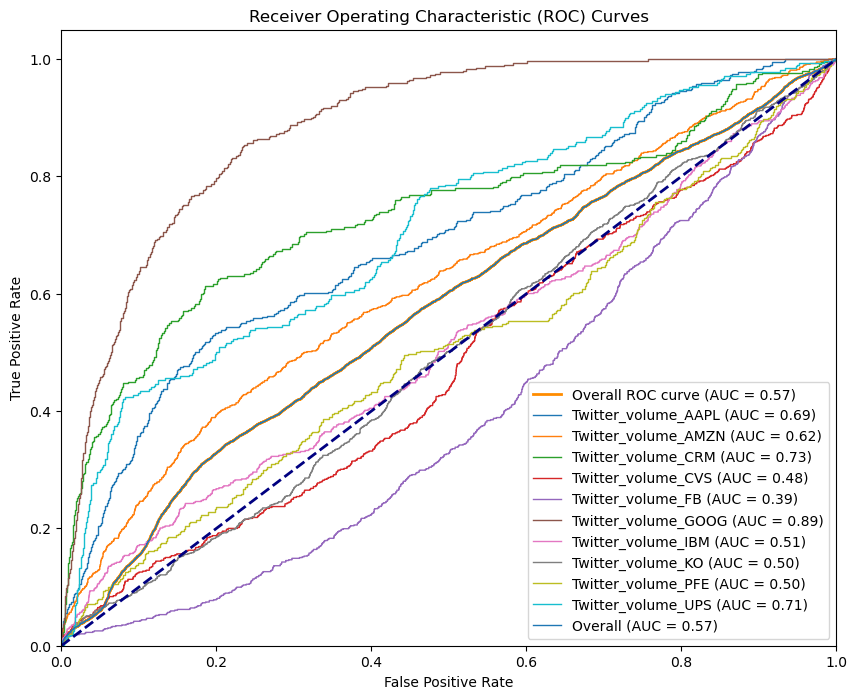


Overall ROC AUC: 0.5731


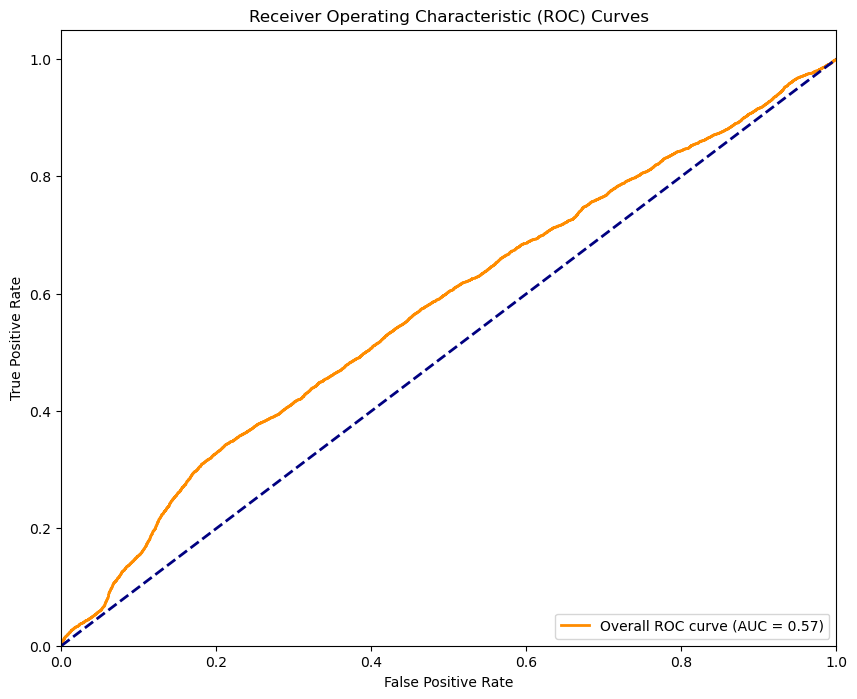

In [7]:
# evaluation with roc curve and classification report 

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([50])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_roc_curves_{config.num_epochs}.png"))
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"all_in_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()


In [8]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: 0.6023
Median: 0.5656
Min: 0.3943
Max: 0.8853



Processing directory: Twitter_volume_AAPL
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 35.67it/s]

IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      7102
         1.0       0.11      0.56      0.18       398

    accuracy                           0.72      7500
   macro avg       0.54      0.65      0.50      7500
weighted avg       0.92      0.72      0.80      7500

ROC AUC: 0.6912

Processing directory: Twitter_volume_AMZN
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.76it/s]

IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.92      0.49      0.64      6708
         1.0       0.13      0.66      0.22       792

    accuracy                           0.50      7500
   macro avg       0.53      0.57      0.43      7500
weighted avg       0.84      0.50      0.59      7500

ROC AUC: 0.6187

Processing directory: Twitter_volume_CRM
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 74.56it/s]

IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94      7151
         1.0       0.21      0.45      0.28       349

    accuracy                           0.89      7500
   macro avg       0.59      0.68      0.61      7500
weighted avg       0.94      0.89      0.91      7500

ROC AUC: 0.7333

Processing directory: Twitter_volume_CVS

Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.85it/s]

IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.84      0.04      0.08      6855
         1.0       0.08      0.91      0.15       645

    accuracy                           0.12      7500
   macro avg       0.46      0.48      0.12      7500
weighted avg       0.77      0.12      0.09      7500

ROC AUC: 0.4768

Processing directory: Twitter_volume_FB
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 74.51it/s]

IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79      6708
         1.0       0.05      0.14      0.08       792

    accuracy                           0.66      7500
   macro avg       0.47      0.43      0.43      7500
weighted avg       0.79      0.66      0.72      7500

ROC AUC: 0.3943

Processing directory: Twitter_volume_GOOG
Number of batches: 3
  0%|          | 0/3 [00:00<?, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 71.32it/s]

IQR outliers classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      7102
         1.0       0.17      0.85      0.28       398

    accuracy                           0.77      7500
   macro avg       0.58      0.81      0.57      7500
weighted avg       0.95      0.77      0.83      7500

ROC AUC: 0.8853

Processing directory: Twitter_volume_IBM
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.24it/s]

IQR outliers classification report for Twitter_volume_IBM

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      6902
         1.0       0.13      0.17      0.14       598

    accuracy                           0.84      7500
   macro avg       0.53      0.53      0.53      7500
weighted avg       0.86      0.84      0.85      7500

ROC AUC: 0.5125

Processing directory: Twitter_volume_KO
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.46it/s]

IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      6440
         1.0       0.13      0.18      0.15      1060

    accuracy                           0.72      7500
   macro avg       0.49      0.49      0.49      7500
weighted avg       0.75      0.72      0.73      7500

ROC AUC: 0.4985

Processing directory: Twitter_volume_PFE
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 73.29it/s]

IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.35      0.51      7102
         1.0       0.05      0.58      0.09       398

    accuracy                           0.37      7500
   macro avg       0.49      0.47      0.30      7500
weighted avg       0.89      0.37      0.49      7500

ROC AUC: 0.5038

Processing directory: Twitter_volume_UPS
Number of batches: 3
100%|██████████| 3/3 [00:00<00:00, 72.29it/s]

IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7182
         1.0       0.19      0.37      0.25       318

    accuracy                           0.91      7500
   macro avg       0.58      0.65      0.60      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.7086

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78     69252
         1.0       0.10      0.45      0.16      5748

    accuracy                           0.65     75000
   macro avg       0.52      0.56      0.47     75000
weighted avg       0.87      0.65      0.73     75000


# NAB dataset - one by one 


Processing directory: Twitter_volume_AAPL


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   7%|▋         | 1/15 [00:02<00:29,  2.12s/it]

Epoch 1/15, Loss: 54015.1640


Training:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]

Epoch 2/15, Loss: 53730.1162


Training:  20%|██        | 3/15 [00:05<00:20,  1.74s/it]

Epoch 3/15, Loss: 40650.5341


Training:  27%|██▋       | 4/15 [00:07<00:18,  1.70s/it]

Epoch 4/15, Loss: 36956.6604


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 37699.2994


Training:  40%|████      | 6/15 [00:10<00:14,  1.66s/it]

Epoch 6/15, Loss: 34468.2570


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7/15, Loss: 41328.1539


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.65s/it]

Epoch 8/15, Loss: 32629.9012


Training:  60%|██████    | 9/15 [00:15<00:09,  1.65s/it]

Epoch 9/15, Loss: 35076.2222


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]

Epoch 10/15, Loss: 34572.5358


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.64s/it]

Epoch 11/15, Loss: 37412.7526


Training:  80%|████████  | 12/15 [00:20<00:04,  1.64s/it]

Epoch 12/15, Loss: 36442.6769


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.64s/it]

Epoch 13/15, Loss: 30070.7399


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.64s/it]

Epoch 14/15, Loss: 31422.7302


Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15/15, Loss: 34611.8865


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.98it/s]



Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      7102
         1.0       0.18      0.35      0.24       398

    accuracy                           0.88      7500
   macro avg       0.57      0.63      0.59      7500
weighted avg       0.92      0.88      0.90      7500

ROC AUC: 0.6705

Processing directory: Twitter_volume_AMZN


Training:   7%|▋         | 1/15 [00:02<00:30,  2.17s/it]

Epoch 1/15, Loss: 3540.9620


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.23s/it]

Epoch 2/15, Loss: 3533.7212


Training:  20%|██        | 3/15 [00:06<00:27,  2.25s/it]

Epoch 3/15, Loss: 2709.3158


Training:  27%|██▋       | 4/15 [00:08<00:22,  2.08s/it]

Epoch 4/15, Loss: 2275.9531


Training:  33%|███▎      | 5/15 [00:10<00:19,  1.93s/it]

Epoch 5/15, Loss: 1546.0386


Training:  40%|████      | 6/15 [00:11<00:16,  1.84s/it]

Epoch 6/15, Loss: 1917.5394


Training:  47%|████▋     | 7/15 [00:13<00:14,  1.78s/it]

Epoch 7/15, Loss: 1169.3687


Training:  53%|█████▎    | 8/15 [00:15<00:12,  1.74s/it]

Epoch 8/15, Loss: 1239.6505


Training:  60%|██████    | 9/15 [00:16<00:10,  1.71s/it]

Epoch 9/15, Loss: 947.9432


Training:  67%|██████▋   | 10/15 [00:18<00:08,  1.69s/it]

Epoch 10/15, Loss: 1144.2067


Training:  73%|███████▎  | 11/15 [00:20<00:06,  1.68s/it]

Epoch 11/15, Loss: 2247.9809


Training:  80%|████████  | 12/15 [00:21<00:05,  1.68s/it]

Epoch 12/15, Loss: 1168.0900


Training:  87%|████████▋ | 13/15 [00:23<00:03,  1.67s/it]

Epoch 13/15, Loss: 1525.6639


Training:  93%|█████████▎| 14/15 [00:25<00:01,  1.66s/it]

Epoch 14/15, Loss: 1277.8061


Training: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


Epoch 15/15, Loss: 1024.7240


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.58it/s]



Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      6708
         1.0       0.26      0.11      0.16       792

    accuracy                           0.87      7500
   macro avg       0.58      0.54      0.54      7500
weighted avg       0.83      0.87      0.85      7500

ROC AUC: 0.5079

Processing directory: Twitter_volume_CRM


Training:   7%|▋         | 1/15 [00:02<00:29,  2.09s/it]

Epoch 1/15, Loss: 21.1866


Training:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]

Epoch 2/15, Loss: 21.1335


Training:  20%|██        | 3/15 [00:05<00:21,  1.75s/it]

Epoch 3/15, Loss: 22.2882


Training:  27%|██▋       | 4/15 [00:07<00:18,  1.71s/it]

Epoch 4/15, Loss: 21.5351


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch 5/15, Loss: 19.2603


Training:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]

Epoch 6/15, Loss: 18.4113


Training:  47%|████▋     | 7/15 [00:12<00:13,  1.68s/it]

Epoch 7/15, Loss: 20.4825


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 20.6668


Training:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]

Epoch 9/15, Loss: 21.8740


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]

Epoch 10/15, Loss: 20.4278


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11/15, Loss: 20.4759


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 18.9122


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]

Epoch 13/15, Loss: 21.6900


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 20.4730


Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]


Epoch 15/15, Loss: 22.1218


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.74it/s]



Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7151
         1.0       0.24      0.43      0.31       349

    accuracy                           0.91      7500
   macro avg       0.60      0.68      0.63      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.6890

Processing directory: Twitter_volume_CVS


Training:   7%|▋         | 1/15 [00:01<00:24,  1.75s/it]

Epoch 1/15, Loss: 1.0211


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]

Epoch 2/15, Loss: 0.9683


Training:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]

Epoch 3/15, Loss: 0.8879


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 0.9006


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]

Epoch 5/15, Loss: 0.8305


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 0.7233


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7/15, Loss: 0.8521


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8/15, Loss: 0.8528


Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9/15, Loss: 0.8808


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch 10/15, Loss: 0.7851


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]

Epoch 11/15, Loss: 0.7682


Training:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]

Epoch 12/15, Loss: 0.8284


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]

Epoch 13/15, Loss: 0.7294


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch 14/15, Loss: 0.8138


Training: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 15/15, Loss: 0.7598


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.12it/s]



Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77      6855
         1.0       0.08      0.30      0.12       645

    accuracy                           0.64      7500
   macro avg       0.49      0.48      0.45      7500
weighted avg       0.84      0.64      0.72      7500

ROC AUC: 0.4503

Processing directory: Twitter_volume_FB


Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]

Epoch 1/15, Loss: 354.1373


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]

Epoch 2/15, Loss: 344.9031


Training:  20%|██        | 3/15 [00:04<00:19,  1.66s/it]

Epoch 3/15, Loss: 247.5761


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]

Epoch 4/15, Loss: 184.6079


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch 5/15, Loss: 184.3101


Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]

Epoch 6/15, Loss: 212.6684


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7/15, Loss: 171.9722


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 175.3000


Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch 9/15, Loss: 194.8921


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]

Epoch 10/15, Loss: 184.1804


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch 11/15, Loss: 157.8539


Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12/15, Loss: 171.3547


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13/15, Loss: 177.8461


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 158.3993


Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15/15, Loss: 133.2945


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.66it/s]



Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      6708
         1.0       0.05      0.04      0.05       792

    accuracy                           0.82      7500
   macro avg       0.47      0.48      0.47      7500
weighted avg       0.80      0.82      0.81      7500

ROC AUC: 0.4087

Processing directory: Twitter_volume_GOOG


Training:   7%|▋         | 1/15 [00:01<00:23,  1.70s/it]

Epoch 1/15, Loss: 439.5256


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.68s/it]

Epoch 2/15, Loss: 365.3570


Training:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]

Epoch 3/15, Loss: 301.3114


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch 4/15, Loss: 293.2161


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch 5/15, Loss: 272.4254


Training:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]

Epoch 6/15, Loss: 270.1115


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7/15, Loss: 269.7241


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8/15, Loss: 260.5177


Training:  60%|██████    | 9/15 [00:14<00:09,  1.65s/it]

Epoch 9/15, Loss: 268.6300


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch 10/15, Loss: 256.8939


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]

Epoch 11/15, Loss: 263.3150


Training:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]

Epoch 12/15, Loss: 345.1092


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13/15, Loss: 364.3631


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]

Epoch 14/15, Loss: 252.4226


Training: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch 15/15, Loss: 226.1918


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.14it/s]



Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      7102
         1.0       0.35      0.55      0.43       398

    accuracy                           0.92      7500
   macro avg       0.66      0.74      0.69      7500
weighted avg       0.94      0.92      0.93      7500

ROC AUC: 0.8133

Processing directory: Twitter_volume_IBM


Training:   7%|▋         | 1/15 [00:01<00:25,  1.81s/it]

Epoch 1/15, Loss: 17.5131


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]

Epoch 2/15, Loss: 13.6915


Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]

Epoch 3/15, Loss: 15.0728


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]

Epoch 4/15, Loss: 12.2354


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]

Epoch 5/15, Loss: 14.1676


Training:  40%|████      | 6/15 [00:10<00:14,  1.67s/it]

Epoch 6/15, Loss: 12.8754


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7/15, Loss: 13.0866


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch 8/15, Loss: 13.6245


Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9/15, Loss: 12.5807


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch 10/15, Loss: 13.0305


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11/15, Loss: 12.4640


Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12/15, Loss: 14.1874


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]

Epoch 13/15, Loss: 13.6728


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 12.9792


Training: 100%|██████████| 15/15 [00:24<00:00,  1.67s/it]


Epoch 15/15, Loss: 13.7592


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.31it/s]



Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      6902
         1.0       0.15      0.16      0.15       598

    accuracy                           0.86      7500
   macro avg       0.54      0.54      0.54      7500
weighted avg       0.86      0.86      0.86      7500

ROC AUC: 0.5125

Processing directory: Twitter_volume_KO


Training:   7%|▋         | 1/15 [00:01<00:23,  1.69s/it]

Epoch 1/15, Loss: 213.9372


Training:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]

Epoch 2/15, Loss: 160.7778


Training:  20%|██        | 3/15 [00:05<00:19,  1.66s/it]

Epoch 3/15, Loss: 178.3292


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch 4/15, Loss: 177.3847


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]

Epoch 5/15, Loss: 170.7585


Training:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]

Epoch 6/15, Loss: 171.5448


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch 7/15, Loss: 187.9054


Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.74s/it]

Epoch 8/15, Loss: 171.7470


Training:  60%|██████    | 9/15 [00:15<00:10,  1.71s/it]

Epoch 9/15, Loss: 184.8421


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.69s/it]

Epoch 10/15, Loss: 183.9229


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch 11/15, Loss: 182.3980


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 200.0294


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]

Epoch 13/15, Loss: 188.0643


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 189.9025


Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15/15, Loss: 174.1907


Testing: 100%|██████████| 3/3 [00:00<00:00, 89.40it/s]



Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      6440
         1.0       0.15      0.08      0.10      1060

    accuracy                           0.81      7500
   macro avg       0.51      0.50      0.50      7500
weighted avg       0.76      0.81      0.78      7500

ROC AUC: 0.5143

Processing directory: Twitter_volume_PFE


Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]

Epoch 1/15, Loss: 2.1175


Training:  13%|█▎        | 2/15 [00:03<00:23,  1.78s/it]

Epoch 2/15, Loss: 2.0043


Training:  20%|██        | 3/15 [00:05<00:22,  1.86s/it]

Epoch 3/15, Loss: 2.0461


Training:  27%|██▋       | 4/15 [00:07<00:19,  1.82s/it]

Epoch 4/15, Loss: 1.9887


Training:  33%|███▎      | 5/15 [00:08<00:17,  1.78s/it]

Epoch 5/15, Loss: 1.8765


Training:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Epoch 6/15, Loss: 2.0075


Training:  47%|████▋     | 7/15 [00:12<00:13,  1.72s/it]

Epoch 7/15, Loss: 1.9080


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.70s/it]

Epoch 8/15, Loss: 1.8533


Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]

Epoch 9/15, Loss: 2.0412


Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]

Epoch 10/15, Loss: 1.8895


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]

Epoch 11/15, Loss: 1.8469


Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]

Epoch 12/15, Loss: 1.7933


Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]

Epoch 13/15, Loss: 2.0368


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 1.9816


Training: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


Epoch 15/15, Loss: 1.8525


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.32it/s]



Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      7102
         1.0       0.09      0.16      0.12       398

    accuracy                           0.87      7500
   macro avg       0.52      0.53      0.52      7500
weighted avg       0.91      0.87      0.89      7500

ROC AUC: 0.5442

Processing directory: Twitter_volume_UPS


Training:   7%|▋         | 1/15 [00:01<00:26,  1.87s/it]

Epoch 1/15, Loss: 702.9203


Training:  13%|█▎        | 2/15 [00:03<00:22,  1.75s/it]

Epoch 2/15, Loss: 570.6143


Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]

Epoch 3/15, Loss: 528.1699


Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]

Epoch 4/15, Loss: 534.5188


Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]

Epoch 5/15, Loss: 523.5883


Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch 6/15, Loss: 531.4749


Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]

Epoch 7/15, Loss: 554.5842


Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]

Epoch 8/15, Loss: 561.6664


Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch 9/15, Loss: 664.7693


Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]

Epoch 10/15, Loss: 850.3812


Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch 11/15, Loss: 451.0864


Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]

Epoch 12/15, Loss: 439.6969


Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]

Epoch 13/15, Loss: 559.6649


Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]

Epoch 14/15, Loss: 466.1548


Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]


Epoch 15/15, Loss: 507.6387


Testing: 100%|██████████| 3/3 [00:00<00:00, 70.29it/s]


Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90      7182
         1.0       0.09      0.34      0.14       318

    accuracy                           0.83      7500
   macro avg       0.53      0.60      0.52      7500
weighted avg       0.93      0.83      0.87      7500

ROC AUC: 0.6632

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     69252
         1.0       0.14      0.20      0.16      5748

    accuracy                           0.84     75000
   macro avg       0.53      0.55      0.54     75000
weighted avg       0.87      0.84      0.86     75000




Overall ROC AUC: 0.5339


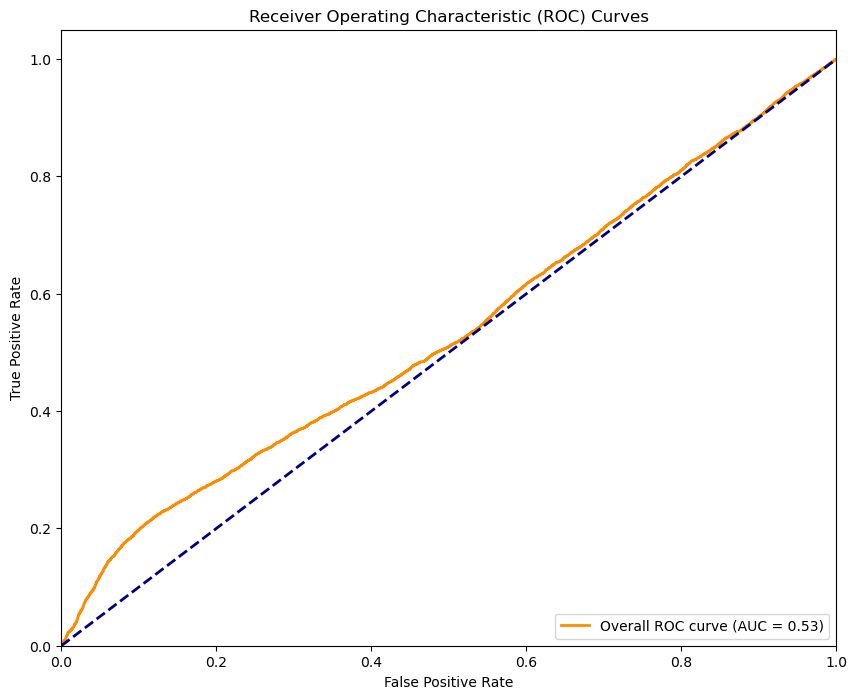

In [9]:
# Main execution
data_folder = "../datasets/UTS/NAB"

noise_scheduler = PinkNoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(sequence_length, stride, input_size, data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_one_overall_roc_curve_{config.num_epochs}.png"))
plt.show()

In [10]:
# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: 0.5774
Median: 0.5293
Min: 0.4087
Max: 0.8133



Processing directory: Twitter_volume_AAPL
Training:   0%|          | 0/15 [00:00<?, ?it/s]
Training:   7%|▋         | 1/15 [00:02<00:29,  2.12s/it]
Epoch 1/15, Loss: 54015.1640
Training:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]
Epoch 2/15, Loss: 53730.1162
Training:  20%|██        | 3/15 [00:05<00:20,  1.74s/it]
Epoch 3/15, Loss: 40650.5341
Training:  27%|██▋       | 4/15 [00:07<00:18,  1.70s/it]
Epoch 4/15, Loss: 36956.6604
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 37699.2994
Training:  40%|████      | 6/15 [00:10<00:14,  1.66s/it]
Epoch 6/15, Loss: 34468.2570
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]
Epoch 7/15, Loss: 41328.1539
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.65s/it]
Epoch 8/15, Loss: 32629.9012
Training:  60%|██████    | 9/15 [00:15<00:09,  1.65s/it]
Epoch 9/15, Loss: 35076.2222
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]
Epoch 10/15, Loss: 34572.5358
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.64s/it]
Epoch 11/15, Loss: 37412.7526
Training:  80%|████████  | 12/15 [00:20<00:04,  1.64s/it]
Epoch 12/15, Loss: 36442.6769
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.64s/it]
Epoch 13/15, Loss: 30070.7399
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.64s/it]
Epoch 14/15, Loss: 31422.7302
Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]
Epoch 15/15, Loss: 34611.8865
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.98it/s]

Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      7102
         1.0       0.18      0.35      0.24       398

    accuracy                           0.88      7500
   macro avg       0.57      0.63      0.59      7500
weighted avg       0.92      0.88      0.90      7500

ROC AUC: 0.6705

Processing directory: Twitter_volume_AMZN
Training:   7%|▋         | 1/15 [00:02<00:30,  2.17s/it]
Epoch 1/15, Loss: 3540.9620
Training:  13%|█▎        | 2/15 [00:04<00:28,  2.23s/it]
Epoch 2/15, Loss: 3533.7212
Training:  20%|██        | 3/15 [00:06<00:27,  2.25s/it]
Epoch 3/15, Loss: 2709.3158
Training:  27%|██▋       | 4/15 [00:08<00:22,  2.08s/it]
Epoch 4/15, Loss: 2275.9531
Training:  33%|███▎      | 5/15 [00:10<00:19,  1.93s/it]
Epoch 5/15, Loss: 1546.0386
Training:  40%|████      | 6/15 [00:11<00:16,  1.84s/it]
Epoch 6/15, Loss: 1917.5394
Training:  47%|████▋     | 7/15 [00:13<00:14,  1.78s/it]
Epoch 7/15, Loss: 1169.3687
Training:  53%|█████▎    | 8/15 [00:15<00:12,  1.74s/it]
Epoch 8/15, Loss: 1239.6505
Training:  60%|██████    | 9/15 [00:16<00:10,  1.71s/it]
Epoch 9/15, Loss: 947.9432
Training:  67%|██████▋   | 10/15 [00:18<00:08,  1.69s/it]
Epoch 10/15, Loss: 1144.2067
Training:  73%|███████▎  | 11/15 [00:20<00:06,  1.68s/it]
Epoch 11/15, Loss: 2247.9809
Training:  80%|████████  | 12/15 [00:21<00:05,  1.68s/it]
Epoch 12/15, Loss: 1168.0900
Training:  87%|████████▋ | 13/15 [00:23<00:03,  1.67s/it]
Epoch 13/15, Loss: 1525.6639
Training:  93%|█████████▎| 14/15 [00:25<00:01,  1.66s/it]
Epoch 14/15, Loss: 1277.8061
Training: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]
Epoch 15/15, Loss: 1024.7240
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.58it/s]

Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      6708
         1.0       0.26      0.11      0.16       792

    accuracy                           0.87      7500
   macro avg       0.58      0.54      0.54      7500
weighted avg       0.83      0.87      0.85      7500

ROC AUC: 0.5079

Processing directory: Twitter_volume_CRM
Training:   7%|▋         | 1/15 [00:02<00:29,  2.09s/it]
Epoch 1/15, Loss: 21.1866
Training:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]
Epoch 2/15, Loss: 21.1335
Training:  20%|██        | 3/15 [00:05<00:21,  1.75s/it]
Epoch 3/15, Loss: 22.2882
Training:  27%|██▋       | 4/15 [00:07<00:18,  1.71s/it]
Epoch 4/15, Loss: 21.5351
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]
Epoch 5/15, Loss: 19.2603
Training:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]
Epoch 6/15, Loss: 18.4113
Training:  47%|████▋     | 7/15 [00:12<00:13,  1.68s/it]
Epoch 7/15, Loss: 20.4825
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 20.6668
Training:  60%|██████    | 9/15 [00:15<00:10,  1.69s/it]
Epoch 9/15, Loss: 21.8740
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]
Epoch 10/15, Loss: 20.4278
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]
Epoch 11/15, Loss: 20.4759
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 18.9122
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]
Epoch 13/15, Loss: 21.6900
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 20.4730
Training: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]
Epoch 15/15, Loss: 22.1218
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.74it/s]

Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      7151
         1.0       0.24      0.43      0.31       349

    accuracy                           0.91      7500
   macro avg       0.60      0.68      0.63      7500
weighted avg       0.94      0.91      0.92      7500

ROC AUC: 0.6890

Processing directory: Twitter_volume_CVS
Training:   7%|▋         | 1/15 [00:01<00:24,  1.75s/it]
Epoch 1/15, Loss: 1.0211
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.69s/it]
Epoch 2/15, Loss: 0.9683
Training:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]
Epoch 3/15, Loss: 0.8879
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 0.9006
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]
Epoch 5/15, Loss: 0.8305
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 0.7233
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]
Epoch 7/15, Loss: 0.8521
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]
Epoch 8/15, Loss: 0.8528
Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]
Epoch 9/15, Loss: 0.8808
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]
Epoch 10/15, Loss: 0.7851
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]
Epoch 11/15, Loss: 0.7682
Training:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]
Epoch 12/15, Loss: 0.8284
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]
Epoch 13/15, Loss: 0.7294
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]
Epoch 14/15, Loss: 0.8138
Training: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]
Epoch 15/15, Loss: 0.7598
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.12it/s]

Classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77      6855
         1.0       0.08      0.30      0.12       645

    accuracy                           0.64      7500
   macro avg       0.49      0.48      0.45      7500
weighted avg       0.84      0.64      0.72      7500

ROC AUC: 0.4503

Processing directory: Twitter_volume_FB
Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]
Epoch 1/15, Loss: 354.1373
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]
Epoch 2/15, Loss: 344.9031
Training:  20%|██        | 3/15 [00:04<00:19,  1.66s/it]
Epoch 3/15, Loss: 247.5761
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]
Epoch 4/15, Loss: 184.6079
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]
Epoch 5/15, Loss: 184.3101
Training:  40%|████      | 6/15 [00:10<00:15,  1.68s/it]
Epoch 6/15, Loss: 212.6684
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]
Epoch 7/15, Loss: 171.9722
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 175.3000
Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]
Epoch 9/15, Loss: 194.8921
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.67s/it]
Epoch 10/15, Loss: 184.1804
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]
Epoch 11/15, Loss: 157.8539
Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]
Epoch 12/15, Loss: 171.3547
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]
Epoch 13/15, Loss: 177.8461
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 158.3993
Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]
Epoch 15/15, Loss: 133.2945
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.66it/s]

Classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      6708
         1.0       0.05      0.04      0.05       792

    accuracy                           0.82      7500
   macro avg       0.47      0.48      0.47      7500
weighted avg       0.80      0.82      0.81      7500

ROC AUC: 0.4087

Processing directory: Twitter_volume_GOOG
Training:   7%|▋         | 1/15 [00:01<00:23,  1.70s/it]
Epoch 1/15, Loss: 439.5256
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.68s/it]
Epoch 2/15, Loss: 365.3570
Training:  20%|██        | 3/15 [00:05<00:20,  1.67s/it]
Epoch 3/15, Loss: 301.3114
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]
Epoch 4/15, Loss: 293.2161
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]
Epoch 5/15, Loss: 272.4254
Training:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]
Epoch 6/15, Loss: 270.1115
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]
Epoch 7/15, Loss: 269.7241
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]
Epoch 8/15, Loss: 260.5177
Training:  60%|██████    | 9/15 [00:14<00:09,  1.65s/it]
Epoch 9/15, Loss: 268.6300
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]
Epoch 10/15, Loss: 256.8939
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.65s/it]
Epoch 11/15, Loss: 263.3150
Training:  80%|████████  | 12/15 [00:19<00:04,  1.66s/it]
Epoch 12/15, Loss: 345.1092
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]
Epoch 13/15, Loss: 364.3631
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.67s/it]
Epoch 14/15, Loss: 252.4226
Training: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]
Epoch 15/15, Loss: 226.1918
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.14it/s]

Classification report for Twitter_volume_GOOG
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      7102
         1.0       0.35      0.55      0.43       398

    accuracy                           0.92      7500
   macro avg       0.66      0.74      0.69      7500
weighted avg       0.94      0.92      0.93      7500

ROC AUC: 0.8133

Processing directory: Twitter_volume_IBM
Training:   7%|▋         | 1/15 [00:01<00:25,  1.81s/it]
Epoch 1/15, Loss: 17.5131
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.72s/it]
Epoch 2/15, Loss: 13.6915
Training:  20%|██        | 3/15 [00:05<00:20,  1.69s/it]
Epoch 3/15, Loss: 15.0728
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.68s/it]
Epoch 4/15, Loss: 12.2354
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.67s/it]
Epoch 5/15, Loss: 14.1676
Training:  40%|████      | 6/15 [00:10<00:14,  1.67s/it]
Epoch 6/15, Loss: 12.8754
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]
Epoch 7/15, Loss: 13.0866
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]
Epoch 8/15, Loss: 13.6245
Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]
Epoch 9/15, Loss: 12.5807
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]
Epoch 10/15, Loss: 13.0305
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]
Epoch 11/15, Loss: 12.4640
Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]
Epoch 12/15, Loss: 14.1874
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.65s/it]
Epoch 13/15, Loss: 13.6728
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 12.9792
Training: 100%|██████████| 15/15 [00:24<00:00,  1.67s/it]
Epoch 15/15, Loss: 13.7592
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.31it/s]

Classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      6902
         1.0       0.15      0.16      0.15       598

    accuracy                           0.86      7500
   macro avg       0.54      0.54      0.54      7500
weighted avg       0.86      0.86      0.86      7500

ROC AUC: 0.5125

Processing directory: Twitter_volume_KO
Training:   7%|▋         | 1/15 [00:01<00:23,  1.69s/it]
Epoch 1/15, Loss: 213.9372
Training:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]
Epoch 2/15, Loss: 160.7778
Training:  20%|██        | 3/15 [00:05<00:19,  1.66s/it]
Epoch 3/15, Loss: 178.3292
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]
Epoch 4/15, Loss: 177.3847
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.66s/it]
Epoch 5/15, Loss: 170.7585
Training:  40%|████      | 6/15 [00:09<00:14,  1.66s/it]
Epoch 6/15, Loss: 171.5448
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]
Epoch 7/15, Loss: 187.9054
Training:  53%|█████▎    | 8/15 [00:13<00:12,  1.74s/it]
Epoch 8/15, Loss: 171.7470
Training:  60%|██████    | 9/15 [00:15<00:10,  1.71s/it]
Epoch 9/15, Loss: 184.8421
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.69s/it]
Epoch 10/15, Loss: 183.9229
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]
Epoch 11/15, Loss: 182.3980
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 200.0294
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.67s/it]
Epoch 13/15, Loss: 188.0643
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 189.9025
Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]
Epoch 15/15, Loss: 174.1907
Testing: 100%|██████████| 3/3 [00:00<00:00, 89.40it/s]

Classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      6440
         1.0       0.15      0.08      0.10      1060

    accuracy                           0.81      7500
   macro avg       0.51      0.50      0.50      7500
weighted avg       0.76      0.81      0.78      7500

ROC AUC: 0.5143

Processing directory: Twitter_volume_PFE
Training:   7%|▋         | 1/15 [00:01<00:23,  1.71s/it]
Epoch 1/15, Loss: 2.1175
Training:  13%|█▎        | 2/15 [00:03<00:23,  1.78s/it]
Epoch 2/15, Loss: 2.0043
Training:  20%|██        | 3/15 [00:05<00:22,  1.86s/it]
Epoch 3/15, Loss: 2.0461
Training:  27%|██▋       | 4/15 [00:07<00:19,  1.82s/it]
Epoch 4/15, Loss: 1.9887
Training:  33%|███▎      | 5/15 [00:08<00:17,  1.78s/it]
Epoch 5/15, Loss: 1.8765
Training:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]
Epoch 6/15, Loss: 2.0075
Training:  47%|████▋     | 7/15 [00:12<00:13,  1.72s/it]
Epoch 7/15, Loss: 1.9080
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.70s/it]
Epoch 8/15, Loss: 1.8533
Training:  60%|██████    | 9/15 [00:15<00:10,  1.68s/it]
Epoch 9/15, Loss: 2.0412
Training:  67%|██████▋   | 10/15 [00:17<00:08,  1.68s/it]
Epoch 10/15, Loss: 1.8895
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.67s/it]
Epoch 11/15, Loss: 1.8469
Training:  80%|████████  | 12/15 [00:20<00:05,  1.67s/it]
Epoch 12/15, Loss: 1.7933
Training:  87%|████████▋ | 13/15 [00:22<00:03,  1.67s/it]
Epoch 13/15, Loss: 2.0368
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 1.9816
Training: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]
Epoch 15/15, Loss: 1.8525
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.32it/s]

Classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      7102
         1.0       0.09      0.16      0.12       398

    accuracy                           0.87      7500
   macro avg       0.52      0.53      0.52      7500
weighted avg       0.91      0.87      0.89      7500

ROC AUC: 0.5442

Processing directory: Twitter_volume_UPS
Training:   7%|▋         | 1/15 [00:01<00:26,  1.87s/it]
Epoch 1/15, Loss: 702.9203
Training:  13%|█▎        | 2/15 [00:03<00:22,  1.75s/it]
Epoch 2/15, Loss: 570.6143
Training:  20%|██        | 3/15 [00:05<00:20,  1.71s/it]
Epoch 3/15, Loss: 528.1699
Training:  27%|██▋       | 4/15 [00:06<00:18,  1.69s/it]
Epoch 4/15, Loss: 534.5188
Training:  33%|███▎      | 5/15 [00:08<00:16,  1.68s/it]
Epoch 5/15, Loss: 523.5883
Training:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]
Epoch 6/15, Loss: 531.4749
Training:  47%|████▋     | 7/15 [00:11<00:13,  1.67s/it]
Epoch 7/15, Loss: 554.5842
Training:  53%|█████▎    | 8/15 [00:13<00:11,  1.67s/it]
Epoch 8/15, Loss: 561.6664
Training:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]
Epoch 9/15, Loss: 664.7693
Training:  67%|██████▋   | 10/15 [00:16<00:08,  1.66s/it]
Epoch 10/15, Loss: 850.3812
Training:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]
Epoch 11/15, Loss: 451.0864
Training:  80%|████████  | 12/15 [00:20<00:04,  1.66s/it]
Epoch 12/15, Loss: 439.6969
Training:  87%|████████▋ | 13/15 [00:21<00:03,  1.66s/it]
Epoch 13/15, Loss: 559.6649
Training:  93%|█████████▎| 14/15 [00:23<00:01,  1.66s/it]
Epoch 14/15, Loss: 466.1548
Training: 100%|██████████| 15/15 [00:25<00:00,  1.67s/it]
Epoch 15/15, Loss: 507.6387
Testing: 100%|██████████| 3/3 [00:00<00:00, 70.29it/s]

Classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90      7182
         1.0       0.09      0.34      0.14       318

    accuracy                           0.83      7500
   macro avg       0.53      0.60      0.52      7500
weighted avg       0.93      0.83      0.87      7500

ROC AUC: 0.6632

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     69252
         1.0       0.14      0.20      0.16      5748

    accuracy                           0.84     75000
   macro avg       0.53      0.55      0.54     75000
weighted avg       0.87      0.84      0.86     75000



Overall ROC AUC: 0.5339

# Yahoo - all in one 

# Yahoo - one by one 